# Treinamento e inferência YOLO_v2
Para a criação da yolo vamos utilizaar e modificar um repositório publico com a implementação da yolo_v2 em keras:
* https://github.com/rodrigo2019/keras_yolo2

### Conjunto de dados
Para treinarmos a YOLO é necessário que nosso conjunto de dados possua as coordenadas do bounding box do objeto. Para criarmos esse conjunto de dados iremos alterar os dados gerados no treinamento de Regressão e transformar as coordenadas x, y em xmin, ymin, xmax, ymax.
A biblioteca da Yolo nos permite carregar os dados de mais de uma maneira, com XML ou CSV, por praticidade iremos utilizar o CSV que funciona da seguinte maneira:

`fname, xmin, ymin, xmax, ymax, label`

caso haja anotações com o mesmo fname, ou seja, mais de uma anotação na imagem, as anotações serão agregadas para a mesma imagem.

In [12]:
import cv2
from matplotlib import pyplot as plt

In [13]:
files = ["ann_train", "ann_val"]
for f in files:
    with open(f"{f}.txt") as ann, open(f"{f}_bbox.txt", "w") as new_ann:
        for line in ann:
            fname, x, y, label = line.strip().split(",")
            image = cv2.imread(fname)
            x = int(x)
            y = int(y)
            # Criação do bbox com tamanho 40x40 utilizando como centro as coordenadas x,y
            xmin = max(x - 20, 0)
            xmax = min(x + 20, image.shape[1] - 1)
            ymin = max(y - 20, 0)
            ymax = min(y + 20, image.shape[0] - 1)
            new_ann.write(f"{fname},{xmin},{ymin},{xmax},{ymax},{label}\n")


##### Visualização do novo conjunto de dados

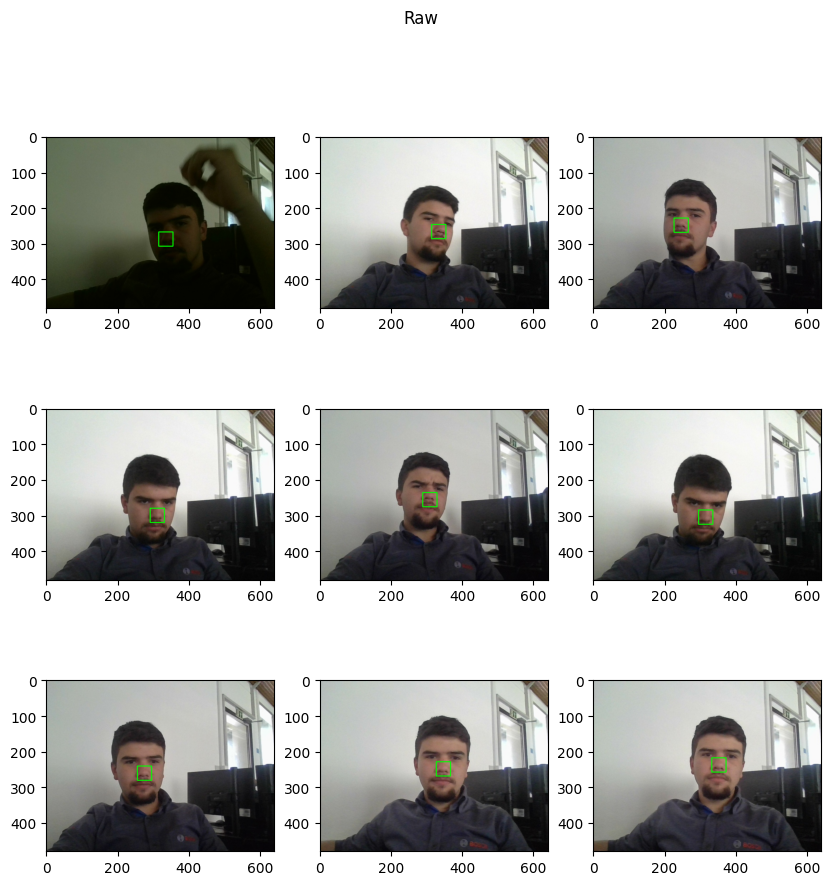

In [14]:
plt.figure(figsize=(10, 10))
with open("ann_val_bbox.txt") as ann:
    for i, line in enumerate(ann):
        if i == 9:
            break
        plt.subplot(3, 3, i + 1)
        fname, xmin, ymin, xmax, ymax, label = line.strip().split(",")
        xmin = int(xmin)
        xmax = int(xmax)
        ymin = int(ymin)
        ymax = int(ymax)
        image = cv2.imread(fname)

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.suptitle('Raw')
    plt.show()


### Treinamento

In [21]:
%run .\keras_yolo2\train.py -c .\keras_yolo2\config.json



Redirecting ../nose_detect.h5 file name to ./yolo_backup\yolo_nose_20221101134028\yolo_nose_20221101134028.h5.
Redirecting ./logs/1 tensorborad log to ./yolo_backup\yolo_nose_20221101134028\logs.
parsing ann_train_bbox.txt csv file can took a while, wait please.


100%|██████████| 133/133 [00:01<00:00, 79.07it/s]


parsing ann_train_bbox.txt csv file can took a while, wait please.


100%|██████████| 133/133 [00:01<00:00, 114.28it/s]


Seen labels:	 {'nose': 132}
Given labels:	 ['nose']
Overlap labels:	 {'nose'}
using fresh backend model
Using a custom backend called yolo_backend.Backend.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (No

### Inferência

In [22]:
from keras_yolov2.frontend import YOLO
import json

In [27]:
with open("keras_yolo2/config.json") as f:
    config = json.loads(f.read())

yolo = YOLO(backend=config['model']['backend'],
            input_size=(config['model']['input_size_h'], config['model']['input_size_w']),
            labels=config['model']['labels'],
            anchors=config['model']['anchors'],
            gray_mode=config['model']['gray_mode'])
yolo.load_weights(r"./yolo_backup\yolo_nose_20221101134028\yolo_nose_20221101134028_bestMap.h5")

using fresh backend model
Using a custom backend called yolo_backend.Backend.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 112, 112, 16)      448       
                                                                 
 batch_normalization_56 (Bat  (None, 112, 112, 16)     64        
 chNormalization)                                                
                                                                 
 re_lu_56 (ReLU)             (None, 112, 112, 16)      0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 56, 56, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 56, 56, 16)        272       
                                          

1/1 [==============================] - 0s 130ms/step


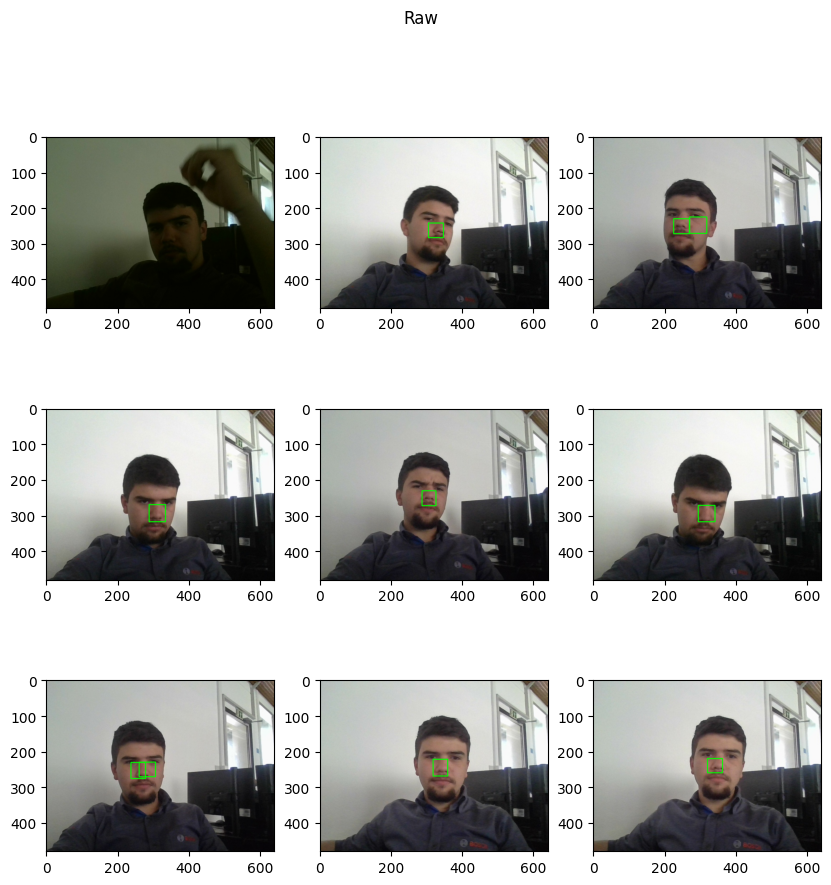

In [28]:
plt.figure(figsize=(10, 10))
with open("ann_val_bbox.txt") as ann:
    for i, line in enumerate(ann):
        if i == 9:
            break
        plt.subplot(3, 3, i + 1)
        fname, _, _, _, _, label = line.strip().split(",")
        image = cv2.imread(fname)
        bboxs = yolo.predict(image)
        for bbox in bboxs:
            xmin = int(bbox.xmin * image.shape[1])
            xmax = int(bbox.xmax * image.shape[1])
            ymin = int(bbox.ymin * image.shape[0])
            ymax = int(bbox.ymax * image.shape[0])
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.suptitle('Raw')
    plt.show()